In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from cm import plot_confusion_matrix
from sklearn import metrics

## Note: the train/test split on this model needs to be refined

In [2]:
parse_dates = ['EventTimeStamp','NextDerateTimestamp']
#faults_sgd_full = pd.read_csv('../data/faults_3_30.csv')
#faults_sgd_full = pd.read_csv('../data/faults_3_15.csv')
#faults_sgd_full = pd.read_csv('../data/faults_3_3.csv')
#faults_sgd_full = pd.read_csv('../data/faults_5_10.csv')
#faults_sgd_full = pd.read_csv('../data/faults_15_15.csv')
faults_sgd_full = pd.read_csv('../data/faults_2_2.csv', parse_dates = parse_dates)
#faults_sgd_full = pd.read_csv('../data/faults_1_2.csv')
#faults_sgd_full = pd.read_csv('../data/faults_2_1.csv')
#faults_sgd_full = pd.read_csv('../data/faults_2_3.csv')
#faults_sgd_full = pd.read_csv('../data/faults_3_2.csv')
#faults_sgd_full = pd.read_csv('../data/faults_1_1.csv')

In [3]:
faults_sgd_full.head()

,EquipmentID,EventTimeStamp,InFailureWindow,NextDerateTimestamp,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,Summ_723,Summ_7827,Summ_7854,Summ_81,Summ_84,Summ_862,Summ_91,Summ_95,Summ_96,Summ_97
0,1327,2015-05-19 12:02:55,0,NaT,14.355,520309.6,185.0,0.0,31.90,203.8438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1327,2015-05-26 08:11:45,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1327,2015-05-26 08:44:10,0,NaT,14.355,520314.6,161.6,45.0,38.86,154.5125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1327,2015-05-28 09:45:18,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1327,2015-06-03 15:24:27,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
equip_ids = pd.DataFrame(faults_sgd_full['EquipmentID'].unique(), columns=['EquipmentID'])
np.random.seed(217)
equip_ids['AssignGroup']=(np.random.randint(0,10000, equip_ids.shape[0]))/10000
equip_ids['ModelGroup'] = np.where(equip_ids['AssignGroup'] <=.65, 'Train', 'Test')
#equip_ids.head()
faults_sgd_full = faults_sgd_full.merge(equip_ids, on=['EquipmentID'])

In [5]:
print(equip_ids.groupby(['ModelGroup'])['AssignGroup'].count())
print(faults_sgd_full.groupby(['ModelGroup'])['InFailureWindow'].sum())
faults_sgd_full.head()

ModelGroup
Test     296
Train    546
Name: AssignGroup, dtype: int64
ModelGroup
Test     686
Train    801
Name: InFailureWindow, dtype: int64


,EquipmentID,EventTimeStamp,InFailureWindow,NextDerateTimestamp,BarometricPressure,DistanceLtd,EngineCoolantTemperature,EngineLoad,EngineOilPressure,EngineOilTemperature,...,Summ_7854,Summ_81,Summ_84,Summ_862,Summ_91,Summ_95,Summ_96,Summ_97,AssignGroup,ModelGroup
0,1327,2015-05-19 12:02:55,0,NaT,14.355,520309.6,185.0,0.0,31.90,203.8438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4754,Train
1,1327,2015-05-26 08:11:45,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4754,Train
2,1327,2015-05-26 08:44:10,0,NaT,14.355,520314.6,161.6,45.0,38.86,154.5125,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4754,Train
3,1327,2015-05-28 09:45:18,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4754,Train
4,1327,2015-06-03 15:24:27,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4754,Train


In [6]:
use_cols = ['ModelGroup','InFailureWindow']
[use_cols.append(col) for col in faults_sgd_full.columns if 'Summ_' in col]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [7]:
faults_sgd= faults_sgd_full[use_cols]
faults_sgd.head()

,ModelGroup,InFailureWindow,Summ_100,Summ_101,Summ_102,Summ_103,Summ_105,Summ_1072,Summ_1075,Summ_108,...,Summ_723,Summ_7827,Summ_7854,Summ_81,Summ_84,Summ_862,Summ_91,Summ_95,Summ_96,Summ_97
0,Train,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Train,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Train,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Train,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Train,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
faults_sgd.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201857 entries, 0 to 201856
Data columns (total 143 columns):
 #    Column           Dtype  
---   ------           -----  
 0    ModelGroup       object 
 1    InFailureWindow  int64  
 2    Summ_100         float64
 3    Summ_101         float64
 4    Summ_102         float64
 5    Summ_103         float64
 6    Summ_105         float64
 7    Summ_1072        float64
 8    Summ_1075        float64
 9    Summ_108         float64
 10   Summ_110         float64
 11   Summ_111         float64
 12   Summ_1127        float64
 13   Summ_1172        float64
 14   Summ_1176        float64
 15   Summ_1209        float64
 16   Summ_1239        float64
 17   Summ_125         float64
 18   Summ_1322        float64
 19   Summ_1323        float64
 20   Summ_1325        float64
 21   Summ_1326        float64
 22   Summ_1328        float64
 23   Summ_1347        float64
 24   Summ_1569        float64
 25   Summ_157         float64
 26   Summ_168      

In [9]:
X = faults_sgd.drop(columns= 'InFailureWindow')
y = faults_sgd[['ModelGroup','InFailureWindow']]

In [10]:
X_train = X[X['ModelGroup']=='Train'].drop(columns = 'ModelGroup')

In [11]:
X_test = X[X['ModelGroup']=='Test'].drop(columns = 'ModelGroup')

In [12]:
y_train = y[y['ModelGroup']=='Train'].drop(columns = 'ModelGroup')

In [13]:
y_test = y[y['ModelGroup']=='Test'].drop(columns = 'ModelGroup')

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 217)

## No balancing

In [15]:
sgd = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log'))
])

In [16]:
sgd.fit(X_train, y_train)

C:\Users\maggi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Pipeline(steps=[('scaler', StandardScaler()),
                ('sgdclass', SGDClassifier(loss='log', random_state=217))])

In [17]:
y_pred = sgd.predict(X_test)
accuracy_score(y_test, y_pred)

0.9876792437715293

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

## Automatic weighting

In [ ]:
sgd_bal = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log', class_weight = 'balanced'))
])
sgd_bal.fit(X_train, y_train)

In [ ]:
y_pred = sgd_bal.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

## Undersampling

In [ ]:
undersampler = RandomUnderSampler(random_state = 217)

In [ ]:
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

In [ ]:
sgd_under = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log'))
])
sgd_under.fit(X_resampled, y_resampled)

In [ ]:
y_pred = sgd_under.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

## Oversampling

In [ ]:
oversampler = RandomOverSampler(random_state = 217)

In [ ]:
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

In [ ]:
sgd_over = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log'))
])
sgd_over.fit(X_resampled, y_resampled)

In [ ]:
y_pred = sgd_over.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

## Combined

In [ ]:
undersampler = RandomOverSampler(random_state = 217, sampling_strategy = 1/3)

In [ ]:
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

In [ ]:
oversampler = RandomOverSampler(random_state = 217)

In [ ]:
X_resampled, y_resampled = oversampler.fit_resample(X_resampled, y_resampled)

In [ ]:
y_resampled.value_counts()

In [ ]:
sgd_comb = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log'))
])
sgd_comb.fit(X_resampled, y_resampled)

In [ ]:
y_pred = sgd_comb.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred))

## SMOTE

In [18]:
oversampler = SMOTE(k_neighbors=5, n_jobs =-1, random_state = 217)

In [19]:
X_smote, y_smote = oversampler.fit_resample(X_train, y_train)

In [20]:
y_smote.value_counts()

InFailureWindow
0                  138641
1                  138641
dtype: int64

In [21]:
sgd_smote = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('sgdclass', SGDClassifier(random_state = 217, loss='log'))
     ])
sgd_smote.fit(X_smote, y_smote.values.ravel())

Pipeline(steps=[('scaler', StandardScaler()),
                ('sgdclass', SGDClassifier(loss='log', random_state=217))])

In [22]:
y_pred = sgd_smote.predict(X_test)
accuracy_score(y_test, y_pred)

0.9385564367539854

In [23]:
confusion_matrix(y_test, y_pred)

array([[58199,  3530],
       [  305,   381]], dtype=int64)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     61729
           1       0.10      0.56      0.17       686

    accuracy                           0.94     62415
   macro avg       0.55      0.75      0.57     62415
weighted avg       0.98      0.94      0.96     62415



In [25]:
# Percent of all cases classified correctly
print('accuracy:', accuracy_score(y_test, y_pred))

# Proportion of 1s classified correctly as 1s
print('sensitivity:', recall_score(y_test, y_pred))

# Proportion of predicted 1s that are actually 1s
print('precision:', precision_score(y_test, y_pred))

# Harmonic mean of precision and recall
print('F1 Score:', f1_score(y_test, y_pred))

accuracy: 0.9385564367539854
sensitivity: 0.5553935860058309
precision: 0.09741754027103043
F1 Score: 0.16576027844246247


In [26]:
y_pred_prob = sgd_smote.predict_proba(X_test)[:,1]

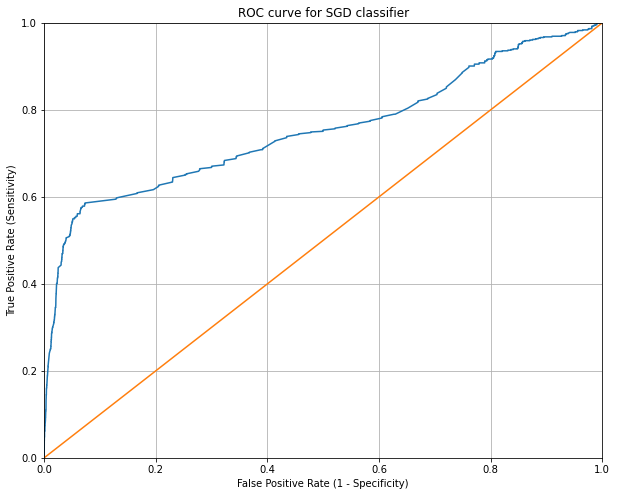

In [27]:
fp_rate, tp_rate, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize = (10,8))

plt.plot(fp_rate, tp_rate)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SGD classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.plot([0,1], [0,1]);

In [28]:
y_pred_prob

array([0.01110507, 0.64273536, 0.84389438, ..., 0.99999693, 0.36577814,
       0.81105632])

In [29]:
y_pred_proba = sgd_smote.predict_proba(X_test)

In [30]:
y_pred_proba

array([[9.88894931e-01, 1.11050689e-02],
       [3.57264641e-01, 6.42735359e-01],
       [1.56105624e-01, 8.43894376e-01],
       ...,
       [3.06798096e-06, 9.99996932e-01],
       [6.34221855e-01, 3.65778145e-01],
       [1.88943682e-01, 8.11056318e-01]])

In [31]:
y_use_prob = pd.DataFrame(y_test.copy())
y_use_prob['predictions'] = y_pred
y_use_prob['pred_prob'] = y_pred_prob
y_use_prob['new_prediction'] = np.where(y_use_prob['pred_prob']>.97,1,0)
y_use_prob

,InFailureWindow,predictions,pred_prob,new_prediction
20,0,0,0.011105,0
21,0,1,0.642735,0
22,0,1,0.843894,0
23,0,1,0.642735,0
24,0,1,0.843894,0
...,...,...,...,...
201391,1,1,0.998573,1
201392,1,1,0.999996,1
201393,1,1,0.999997,1
201394,0,0,0.365778,0


In [32]:
y_pred_new = np.array(y_use_prob['new_prediction'])

In [33]:
accuracy_score(y_test, y_pred_new)

0.9827445325642874

In [34]:
confusion_matrix(y_test, y_pred_new)

array([[61174,   555],
       [  522,   164]], dtype=int64)

In [35]:
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     61729
           1       0.23      0.24      0.23       686

    accuracy                           0.98     62415
   macro avg       0.61      0.62      0.61     62415
weighted avg       0.98      0.98      0.98     62415



In [36]:
# Percent of all cases classified correctly
print('accuracy:', accuracy_score(y_test, y_pred_new))

# Proportion of 1s classified correctly as 1s
print('sensitivity:', recall_score(y_test, y_pred_new))

# Proportion of predicted 1s that are actually 1s
print('precision:', precision_score(y_test, y_pred_new))

# Harmonic mean of precision and recall
print('F1 Score:', f1_score(y_test, y_pred_new))

accuracy: 0.9827445325642874
sensitivity: 0.239067055393586
precision: 0.22809457579972184
F1 Score: 0.23345195729537366


In [37]:
#fp_rate, tp_rate, thresholds 

## Compute dollar value of predictions

In [45]:
# Merge the predictions with y_test
y_test_compare = pd.DataFrame(y_test.copy())
y_test_compare['predictions'] = y_pred_new#y_pred
y_test_compare = y_test_compare.merge(faults_sgd_full, left_index=True, right_index=True)

#Manually calc our confusion matrix numbers
y_test_compare['TrueNegative'] = np.where((y_test_compare['InFailureWindow_x']==0) & (y_test_compare['predictions']==0),1,0)
y_test_compare['FalseNegative'] = np.where((y_test_compare['InFailureWindow_x']==1) & (y_test_compare['predictions']==0),1,0)
y_test_compare['TruePositive'] = np.where((y_test_compare['InFailureWindow_x']==1) & (y_test_compare['predictions']==1),1,0)
y_test_compare['FalsePositive'] = np.where((y_test_compare['InFailureWindow_x']==0) & (y_test_compare['predictions']==1),1,0)

#Come up with some dollars
y_test_compare['NextDerateTimestamp'] = y_test_compare['NextDerateTimestamp'].fillna(datetime.strptime('Dec 31 2099  11:59PM', '%b %d %Y %I:%M%p'))

y_test_compareTP = y_test_compare.groupby(['EquipmentID','NextDerateTimestamp'])[['TruePositive']].sum()
y_test_compareTP['SavingsPerTruePositive'] = np.where(y_test_compareTP['TruePositive']>0,4000,0)

y_test_compareFP = y_test_compare[['EquipmentID','EventTimeStamp','FalsePositive']]
y_test_compareFP['EventTimeStamp'] = y_test_compareFP['EventTimeStamp'].dt.date
y_test_compareFP = y_test_compareFP.groupby(['EquipmentID','EventTimeStamp'])[['FalsePositive']].max()
y_test_compareFP['FalsePositive'].sum()


#Calc and print the totals
max_derate = y_test_compare['NextDerateTimestamp'].max()
#print(max_derate)
derate_count = y_test_compare[y_test_compare['NextDerateTimestamp']<max_derate]['NextDerateTimestamp'].nunique()
print('Derate count: ', derate_count)
derate_expense = derate_count * 4000
print('Expense @ $4,000 per: ', derate_expense)
pred_savings = y_test_compareTP['SavingsPerTruePositive'].sum()
print('Faults predicted: ', pred_savings / 4000)
print('Savings @ $4,000 per: ', pred_savings)
false_pos = y_test_compareFP.sum()
print('False alarms predicted: ', false_pos)
pred_exp = false_pos * 500
print('Expense @ $500 per: ', pred_exp)
#net_savings = pred_savings - pred_exp
#print('Net Savings: ', net_savings)

Derate count:  77
Expense @ $4,000 per:  308000
Faults predicted:  40.0
Savings @ $4,000 per:  160000
False alarms predicted:  FalsePositive    263
dtype: int64
Expense @ $500 per:  FalsePositive    131500
dtype: int64


In [84]:
TruePositive = y_test_compare[y_test_compare['TruePositive']!=0]['TruePositive'].count()
print('True Positive: ', TruePositive)
FalsePositive = y_test_compare[y_test_compare['FalsePositive']!=0]['FalsePositive'].count()
print('False Positive: ', FalsePositive)
FalseNegative = pd.DataFrame(np.where((y_test_compare['FalseNegative']!=0) & 
                                      (y_test_compare['TruePositive']==0))).shape[1]
print('False Negative: ', FalseNegative)
TrueNegative = pd.DataFrame(np.where((y_test_compare['TrueNegative']!=0) & (y_test_compare['TruePositive']==0) &
                     (y_test_compare['FalsePositive']==0) & (y_test_compare['FalseNegative']==0))).shape[1]
print('True Negative: ', TrueNegative)

True Positive:  164
False Positive:  555
False Negative:  522
True Negative:  61174


In [76]:
coefs = sgd_smote[1].coef_
coefs[0].shape

(141,)

In [80]:
X.columns[1:]

Index(['Summ_100', 'Summ_101', 'Summ_102', 'Summ_103', 'Summ_105', 'Summ_1072',
       'Summ_1075', 'Summ_108', 'Summ_110', 'Summ_111',
       ...
       'Summ_723', 'Summ_7827', 'Summ_7854', 'Summ_81', 'Summ_84', 'Summ_862',
       'Summ_91', 'Summ_95', 'Summ_96', 'Summ_97'],
      dtype='object', length=141)

In [82]:
pd.DataFrame(coefs[0], X.columns[1:], columns = ['coef']).sort_values('coef', ascending=False).head(10)

,coef
Summ_3362,2.935813
Summ_6802,1.925481
Summ_4340,1.322934
Summ_3216,1.145996
Summ_3218,1.010679
Summ_5743,0.975570
Summ_105,0.967898
Summ_3031,0.857858
Summ_5394,0.691147
Summ_4094,0.639505


In [83]:
pd.DataFrame(coefs[0], X.columns[1:], columns = ['coef']).sort_values('coef', ascending=False).tail(10)

,coef
Summ_110,-0.626872
Summ_5853,-0.648607
Summ_5746,-0.703947
Summ_3228,-0.709502
Summ_4339,-0.729684
Summ_3222,-0.915340
Summ_641,-0.941860
Summ_91,-1.012627
Summ_3251,-1.783201
Summ_97,-3.312246


## Model scoring log

15/15 model stats
accuracy: 0.9246598075008298
sensitivity: 0.512273212379936
precision: 0.13132694938440492
F1 Score: 0.20905923344947736

15/15 model stats w/standard scaler
accuracy: 0.9182085960836376
sensitivity: 0.5346851654215582
precision: 0.125
F1 Score: 0.20262891809909

5/10 model stats
accuracy: 0.9397536666396564
sensitivity: 0.6173570019723866
precision: 0.10119624959586163
F1 Score: 0.1738888888888889

5/10 model stats w/standard scaler
accuracy: 0.9332306944331902
sensitivity: 0.6528599605522682
precision: 0.09591422776006954
F1 Score: 0.16725618999494696

3/3 model stats
accuracy: 0.9429271499432259
sensitivity: 0.6391509433962265
precision: 0.09084813945692256
F1 Score: 0.15908423833284416

3/3 model stats w/standard scaler
accuracy: 0.9473296280802407
sensitivity: 0.6297169811320755
precision: 0.09694989106753812
F1 Score: 0.16803020767778476

3/15 model stats
accuracy: 0.9398675496688742
sensitivity: 0.7432098765432099
precision: 0.09561626429479034
F1 Score: 0.16943428088938925

3/15 model w/standard scaler
accuracy: 0.9334080489047376
sensitivity: 0.7432098765432099
precision: 0.08686868686868687
F1 Score: 0.15555555555555556

3/30 model stats
accuracy: 0.3530028738646137
sensitivity: 0.9047619047619048
precision: 0.011583135468138356
F1 Score: 0.022873435767463965

3/30 model w/standard scaler
accuracy: 0.921105074363869
sensitivity: 0.7243107769423559
precision: 0.0733502538071066
F1 Score: 0.133210417146808

2/2 model w/standard scaler
accuracy: 0.9437431883483602
sensitivity: 0.7526881720430108
precision: 0.09250082590023125
F1 Score: 0.16475433951162105

2/2 model no scaler
accuracy: 0.938300088119843
sensitivity: 0.5991253644314869
precision: 0.10308502633559068
F1 Score: 0.1759041301091376

1/2 model w/standard scaler
accuracy: 0.9442093188829997
sensitivity: 0.7682119205298014
precision: 0.07777405296681193
F1 Score: 0.14124809741248098

2/1 model w/standard scaler
accuracy: 0.9444356717066046
sensitivity: 0.701058201058201
precision: 0.08931580721267274
F1 Score: 0.15844544095665172

2/3 model w/standard scaler
accuracy: 0.945498289986479
sensitivity: 0.7146739130434783
precision: 0.09072093825457055
F1 Score: 0.1610039791857974

3/2 model w/standard scaler
accuracy: 0.943380119513212
sensitivity: 0.6495327102803738
precision: 0.09328859060402685
F1 Score: 0.16314553990610328

1/1 model w/standard scaler
accuracy: 0.9436378321940072
sensitivity: 0.762987012987013
precision: 0.07773734700628515
F1 Score: 0.1410987691383969

2/2 random forest
accuracy: 0.9583275537501238
sensitivity: 0.5833333333333334
precision: 0.10023094688221709
F1 Score: 0.17106819077650767

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
forest_clf = RandomForestClassifier(random_state=217)
#y_probas_forest = cross_val_predict(forest_clf, X_smote, y_smote.values.ravel(), cv=3, method='predict_proba')

In [48]:
forest_clf.fit(X_smote, y_smote.values.ravel())

RandomForestClassifier(random_state=217)

In [49]:
y_pred = forest_clf.predict(X_test)

In [50]:
accuracy_score(y_test, y_pred)

0.9474004646318994

In [51]:
confusion_matrix(y_test, y_pred)

array([[58930,  2799],
       [  484,   202]], dtype=int64)

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     61729
           1       0.07      0.29      0.11       686

    accuracy                           0.95     62415
   macro avg       0.53      0.62      0.54     62415
weighted avg       0.98      0.95      0.96     62415



In [ ]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_smote, y_scores_forest)

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

In [ ]:
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

In [ ]:
y_scores = cross_val_predict(sgd_smote, X_smote, y_smote, cv=3, method='decision_function')
fpr, tpr, thresholds = roc_curve(y_smote, y_scores)

In [ ]:
plot_roc_curve(fpr, tpr, "SGD Classifier")

In [ ]:
faults_sgd[['Summ_5394','Summ_1761','Summ_4094','Summ_4334','Summ_4339']].sum()
#'Summ_5392',

add a lasso to the above
in the presentation, talk about what the coefficients are, what it's using, what it's ignoring
for decision trees, you can talk about feature importance
when evaluating models, as long as you have one correct prediction then you have a win
what are the observations where it feels the strongest about them ... what were the characteristics on those
i.e., if you look at predicted probababilities like what is at the upper end
where were your false negatives in the range of probabilities?
